# Historical change 

Even if the core meaning of community has not changed over the 20th century, it might have evolved new connotations or come to be used in new contexts. Here I examine the temporal stability of "community" using historical word embeddings.

Both NLP researchers and social scientists have used word embeddings to study semantic change over time. To do this, distinct embeddings models are trained on different time periods, and then embeddings for particular words can be compared. (Comparing vectors *across* models is a tricky problem, see below.) 

For instance, the word "gay" shifted from meaning "happy" to meaning "homosexual" in the mid-late 20th century. Multiple historical embeddings papers (Kulkarni et al 2015, Hamilton et al 2016) use this example to demonstrate that embeddings can encode and uncover this kind of semantic change. Mendelsohn et al (2020) extend this work further by noting a more recent shift (since the 1980s) in the valence or connotation of the word "gay", from more negative to more positive. I'll use this conventional example as a comparison and reference in my explorations of "community" below.

To measure and visualize semantic change over time, researchers adapt the same metrics of cosine similarity and distance used for other comparisons. First, the simplest approach is to calculate the similarity between a pair of words *within* each time period, and then to show how that similarity measure increases or decreases over time. This can be generalized to compare, for instance, binary axes across time (Kozlowski et al 2019). Second, a single word can be compared with itself *across* time periods; for instance, the distance from a word's vector in the first time period can be calculated for each subsequent time period. Finally, distances can be projected into two-dimensions with dimensionality-reduction techniques like t-SNE, to visualize how a focal word moves in relation to other neighboring words.

The most common source for historical word coocurrence data is the Google Ngram corpus (for instance, Kulkarni et al 2015, Hamilton et al 2016, Kozlowski et al 2019). An N-gram is a series of words of length N. Embeddings trained on Google Ngrams typically use 5-grams only. Because the composition of the Google Ngram corpus shifts over the 20th century and especially in the 2000s, it generally isn't considered comparable after the 1990s (Pechenick et al 2015, note that they recommend the fiction corpus over the all-English corpus). This makes it difficult to bridge the gap with contemporary embeddings trained on Wikipedia and Twitter.

Alternative data sources include the Corpus of Historical American English (COHA, used in Hamilton et al 2016 and Stoltz and Taylor 2020), and articles published in the New York Times (Mendelsohn et al 2020; Arseniev-Koehler and Foster 2020 also use a 30-year NYT corpus, but do not train separate models on different years). 

## Notes on prior methods & code

### HistWords (Hamilton et al 2016)

https://nlp.stanford.edu/projects/histwords/

https://github.com/williamleif/histwords

I download and use these pretrained historical embeddings from Histwords. These HistWords embeddings are trained on Google N-Grams with skip-gram negative sampling / word2vec. I primarily use the all-English embeddings, but I've also briefly investigated the fiction embeddings. They use 10-year time periods from 1800 through 1990, inclusive. 

Hamilton's research code is written in Python 2, and he recommends using gensim instead. In a previous iteration of this notebook, I was able to get some of his code, for loading the historical embeddings and calculating pairwise cosine similarities over time, to run in Python 3 with a few modifications. (I don't recommend ad-hoc modifying code like that!)

The [viz code](https://github.com/williamleif/histwords/tree/master/viz), including an interactive explorer, can be run in a separate Python 2 conda environment. As the readme notes for macOS, I had to use pythonw in place of python. 

To install a python 2.7 environment to run the original histwords code:

```
conda create -n histwords-env python=2.7
conda activate histwords-env
pip install -r requirements.txt
conda install python.app
```

Then to generate plots in viz/output/: 

```
pythonw scripts/closest_over_time_with_anns.py community
```

The static plot code is hard-coded to use the all-English embeddings. 

This viz code produces more detailed plots than the simplified diagrams in the actual paper. I found the code challenging to read, and I'm not certain that the t-SNE plots it produces exactly match the algorithm outlined in Appendix B of the paper. The key difference (I think!) is that the algorithm in the paper describes using one set of nearest neighbors for all years, and holds all words but the focal word fixed at the latest value when recalculating the position of the focal word. The code actually calculates a new t-SNE on all the nearest neighbors for a given year, which means that other words can move as well. If other words' embeddings change little, results should be fairly similar.

Hamilton et al's measure of **polysemy** is also of interest to me, potentially for future investigation, because my intuition is that "community" is a relatively polysemous concept. They operationalize polysemy as "contextual diversity", constructing a cooccurence network on the top 10,000 words, excluding stopwords, using PPMI. They then use a local clustering coefficient on that network, citing Watts and Strogatz. 

For their regression analyses, they use normalized cosine distances between time t and time t+1. This doesn't feature in their plots of individual words.

### Kulkarni et al 2015

https://github.com/viveksck/langchangetrack

https://github.com/viveksck/changepoint

This paper precedes Hamilton et al, but I haven't read through the code or attempted to run it. According to the paper, they align matrices by piecewise linear regression and then create a time series of distances from the original position of the word at time zero. The y-axes of their figures are those distances. The distance metric they use seems to be cosine distance as well.

### Kozlowski et al 2019

https://github.com/KnowledgeLab/GeometryofCulture/

They plot pairwise cosine similarity over time between different binary dimensions of social class and the dimension of affluence. They repeat this plot for six other dimensions. They do this for the Google Ngram corpus in the main paper, and repeat it for the JSTOR Sociology corpus in the appendix.

They also plot the correlation of the projections of vocabulary words onto each of these seven dimensions over time. This projection [is equivalent to cosine similarity](https://github.com/KnowledgeLab/GeometryofCulture/blob/master/code/build_cultural_dimensions.R#L68) between the words and the dimensions. I need to read the code more closely, but this may also be akin to [the `>>` operator in whatlies](https://github.com/RasaHQ/whatlies/blob/master/whatlies/embedding.py#L132).

The repository includes example scripts, rather than complete replication code.

### Stoltz and Taylor 2020

Stoltz and Taylor use pretrained HistWords embeddings. Specifically, they use the genre-balanced COHA embeddings. They plot changes in pairwise cosine similarity. They also plot cosine similarity of particular words to two binary axes simultaneously over time. 

This paper cites several other papers which use embeddings for comparison, some of which I'm not personally familiar with. 

The paper is forthcoming in Poetics. The authors generally publish their code, but this paper's code is not yet shared on either author's GitHub.

### Mendelsoh et al 2020

Their code is not available, but their measures of connotations and valence seem promising.

## Load packages and embeddings

In [1]:
# load packages
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from gensim.models import KeyedVectors
from gensim.matutils import unitvec
from whatlies import EmbeddingSet, Embedding
from whatlies.transformers import Normalizer, Tsne
from sklearn.manifold import TSNE

In [2]:
# load histwords as gensim KeyedVectors
def load_historical_embeddings(year, 
                               path="historical-embeddings/eng-all_sgns/"):
    with open(path + str(year) + "-vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    
    vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")
    
    kv = KeyedVectors(vector_size=vectors.shape[1])
    kv.add(entities=vocab, weights=vectors)

    return kv

In [3]:
# alt: load histwords as whatlies EmbeddingSet
def load_historical_embeddingset(year, 
                                 path="historical-embeddings/eng-all_sgns/"):
    with open(path + str(year) + "-vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    
    vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")

    return EmbeddingSet.from_names_X(vocab, vectors)

The gensim syntax for calculating similarity is a bit less awkward than whatlies, and produces the same results, so I'll use gensim here.

For reference, cosine similarity is the dot product of the normed vectors. Links to code:  

- https://github.com/williamleif/histwords/blob/master/representations/embedding.py#L76
- https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py#L1143

In [4]:
emb_hist = OrderedDict()
for year in range(1900, 2000, 10):
    emb_hist[year] = load_historical_embeddings(year)

In [5]:
emb_fic = OrderedDict()
fic_path = 'historical-embeddings/eng-fiction-all_sgns/'
for year in range(1900, 2000, 10):
    emb_fic[year] = load_historical_embeddings(year, path=fic_path)

## Words most similar to community 

For the all-English embeddings in the 1990s, these are the words most similar to "community". (In gensim, this excludes the word "community" itself, unlike when using whatlies.)

The ECSC is the European Coal and Steel Community, a predecessor to the EU.

In [6]:
emb_hist[1990].most_similar("community", topn=10)

/Users/cgilroy/miniconda3/envs/text-env/lib/python3.8/site-packages/gensim/models/keyedvectors.py:2389: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


[('communities', 0.5092913508415222),
 ('family', 0.4234296679496765),
 ('welfare', 0.39216965436935425),
 ('members', 0.3888649344444275),
 ('society', 0.381721168756485),
 ('citizens', 0.3795493245124817),
 ('institutions', 0.3793562948703766),
 ('organisation', 0.37624260783195496),
 ('ecsc', 0.37549275159835815),
 ('stakeholders', 0.3671599328517914)]

In [7]:
hist_com10 = []
for year in emb_hist:
    w, s = zip(*emb_hist[year].most_similar("community", topn=20))
    hist_com10.append(pd.Series(data=w, name=year))

In [8]:
pd.DataFrame(hist_com10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1900,nation,communities,individual,welfare,members,country,social,interests,abiding,influential,poorer,citizens,classes,people,individuals,civilised,mankind,society,civilized,wealthy
1910,nation,welfare,people,interests,communities,poorer,social,citizens,upbuilding,individual,wellbeing,betterment,country,members,benefit,mankind,class,classes,family,detriment
1920,communities,upbuilding,nation,citizens,welfare,individual,interests,betterment,detrimental,wellbeing,civic,detriment,people,social,family,individuals,poorer,collective,civilised,citizen
1930,communities,citizens,family,welfare,individuals,nation,cultural,needs,jewish,social,poorer,classes,individual,residents,respected,organizations,wellbeing,groups,citizen,civilized
1940,nation,communities,family,welfare,residents,citizens,jewish,cultural,civic,clan,tribe,rural,members,poorer,civilized,organization,urban,people,interests,respected
1950,communities,welfare,family,citizens,civic,nation,residents,jewish,interests,members,individuals,social,individual,detriment,ethnic,local,organizations,groups,edc,cultural
1960,communities,nation,yishuv,welfare,sectors,family,undp,civic,social,organization,landowning,jewish,redevelopment,members,rural,interests,neighborhood,needs,european,solidarity
1970,communities,neighborhood,nation,family,group,welfare,organization,blassingame,members,hmos,jewish,wellbeing,citizens,whole,solidarity,european,ethnical,neighborhoods,unmet,civic
1980,communities,nation,jewish,family,institutions,believers,members,european,social,organization,health,civic,citizens,eec,church,mainstream,welfare,centers,interests,sectors
1990,communities,family,welfare,members,society,citizens,institutions,organisation,ecsc,stakeholders,families,civic,member,nation,elite,organization,european,believers,social,health


In [9]:
fic_com10 = []
for year in emb_fic:
    w, s = zip(*emb_fic[year].most_similar("community", topn=20))
    fic_com10.append(pd.Series(data=w, name=year))
pd.DataFrame(fic_com10)

/Users/cgilroy/miniconda3/envs/text-env/lib/python3.8/site-packages/gensim/models/keyedvectors.py:2389: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1900,classes,citizens,welfare,interests,society,nation,people,benefit,mankind,preservation,members,class,respectable,jewish,aristocracy,lives,section,social,individual,property
1910,nation,interests,mankind,jewish,members,welfare,individual,population,classes,social,property,citizen,people,class,leaders,representatives,prominent,representative,prosperity,county
1920,welfare,classes,nation,representatives,section,lives,citizens,influential,interests,abiding,property,class,responsible,social,institutions,poorer,representative,loyal,development,moral
1930,interests,members,classes,society,citizens,member,welfare,nation,mankind,preservation,tribe,family,jewish,section,population,country,race,class,social,leaders
1940,family,interests,member,welfare,jewish,society,classes,members,nation,social,citizens,leaders,property,class,individual,culture,respectable,respected,section,preservation
1950,nation,welfare,members,status,member,society,social,individual,mankind,family,citizens,representatives,interests,promote,organization,people,clergy,unit,maintenance,unity
1960,social,integral,cultural,society,minority,culture,member,jewish,nation,residents,members,dominant,industrial,organization,population,family,citizens,status,respected,people
1970,society,members,individual,urban,values,preservation,social,nation,culture,jewish,family,welfare,minority,citizens,member,leadership,establishment,respected,tribe,citizen
1980,society,family,elite,urban,members,member,organization,stability,social,respected,hierarchy,culture,population,emergence,segment,gender,wealthiest,cult,people,citizens
1990,society,policing,ethnic,homophobia,transgender,panchsheel,elite,family,nation,propagation,pvt,lesbian,social,member,intellectuals,members,gay,integral,people,influential


For the embeddings based on English fiction, I find it intriguing that LGBT-related words begin to appear on the list in the 1990s. I've expanded the list of nearest neighbors to the top 20 so this is more apparent -- not only "homophobia" and "transgender", but also "lesbian" and "gay".

Note that, aside from "gay" (which exists with a non-LGBT meaning) most of these words aren't common enough to appear in the vocabulary at all before 1970 or so. HistWords handles this by setting the vectors for those words to all 0s.

In [10]:
emb_hist[1960].get_vector("lesbian")[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
emb_fic[1960]["lesbian"][0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Pairwise cosine similarity

For instance, largely as a consequence of the shift in the meaning of the word "gay", the cosine similarity between "community" and "gay" increases over the course of the 20th century. The words become more similar. 

In [12]:
emb_hist[1900].similarity("community", "gay")

-0.038824234

In [13]:
emb_hist[1990].similarity("community", "gay")

0.26311922

In [14]:
def get_similarity_over_time(emb_hist, w1, w2):
    df = pd.DataFrame(emb_hist.keys(), columns=["year"])
    
    df["similarity"] = [emb_hist[year].similarity(w1, w2) for year in emb_hist]
    
    df["word1"] = w1
    df["word2"] = w2
    
    return df

In [15]:
df_gay = get_similarity_over_time(emb_hist, "community", "gay")
df_gay

,year,similarity,word1,word2
0,1900,-0.038824,community,gay
1,1910,-0.107995,community,gay
2,1920,-0.126219,community,gay
3,1930,-0.122056,community,gay
4,1940,-0.089771,community,gay
5,1950,-0.120643,community,gay
6,1960,-0.150094,community,gay
7,1970,0.096877,community,gay
8,1980,0.158089,community,gay
9,1990,0.263119,community,gay


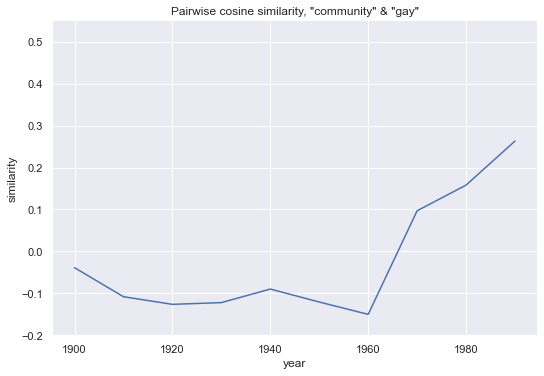

In [16]:
sns.set_theme()
g = sns.relplot(data=df_gay, x='year', y='similarity', 
                kind="line")
g.ax.set(ylim=(-.2, .55))
g.ax.set_title('Pairwise cosine similarity, "community" & "gay"')
g.fig.set_figwidth(8)
plt.show()

In [17]:
df_neighborhood = get_similarity_over_time(emb_hist, "community", "neighborhood")

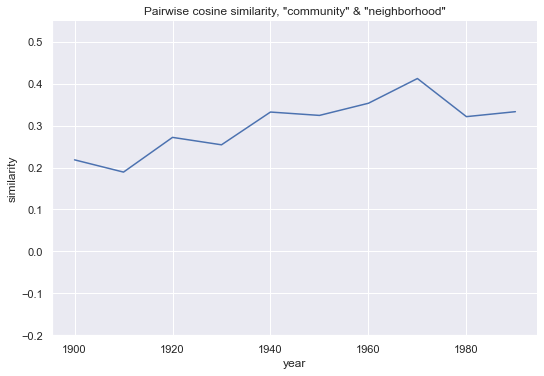

In [18]:
sns.set_theme()
g = sns.relplot(data=df_neighborhood, x='year', y='similarity', 
                kind="line")
g.ax.set(ylim=(-.2, .55))
g.ax.set_title('Pairwise cosine similarity, "community" & "neighborhood"')
g.fig.set_figwidth(8)
plt.show()

In [19]:
df_nation = get_similarity_over_time(emb_hist, "community", "nation")

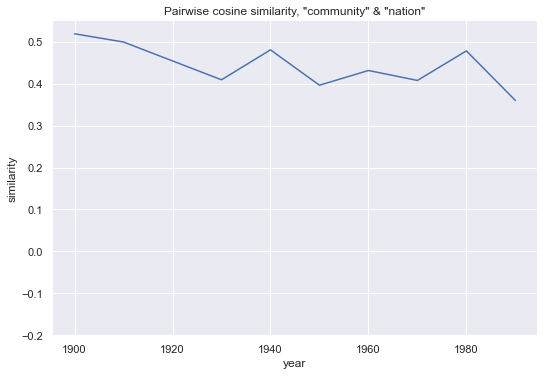

In [20]:
g = sns.relplot(data=df_nation, x='year', y='similarity', 
                kind="line")
g.ax.set_title('Pairwise cosine similarity, "community" & "nation"')
g.ax.set(ylim=(-.2, .55))
g.fig.set_figwidth(8)
plt.show()

In [21]:
df_society = get_similarity_over_time(emb_hist, "community", "society")

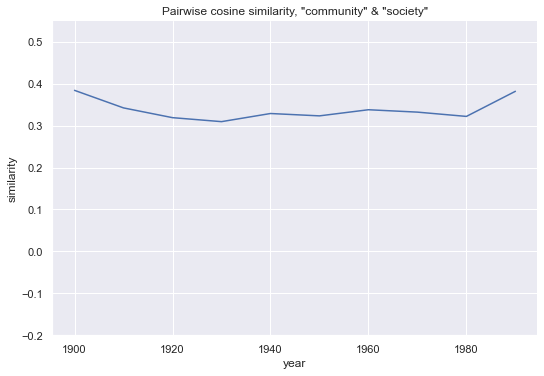

In [22]:
g = sns.relplot(data=df_society, x='year', y='similarity', 
                kind="line")
g.ax.set(ylim=(-.2, .55))
g.ax.set_title('Pairwise cosine similarity, "community" & "society"')
g.fig.set_figwidth(8)
plt.show()

TODO: INTERPRET

In [23]:
df_gay_fic = get_similarity_over_time(emb_fic, "community", "gay")
df_gay_fic

,year,similarity,word1,word2
0,1900,0.020447,community,gay
1,1910,0.040731,community,gay
2,1920,0.035118,community,gay
3,1930,-0.010864,community,gay
4,1940,0.035275,community,gay
5,1950,0.036227,community,gay
6,1960,0.078445,community,gay
7,1970,0.217126,community,gay
8,1980,0.246994,community,gay
9,1990,0.345665,community,gay


## Self-similarity

In [24]:
# cosine distance from t-0
# like Kulkarni et al
for year in emb_hist:
    # unitvec is in gensim.matutils
    cos_sim = np.dot(unitvec(emb_hist[1900]["community"]), 
                     unitvec(emb_hist[year]["community"]))
    cos_dist = 1 - cos_sim
    print(str(year) + ": " + str(cos_dist))

1900: 0.0
1910: 0.24373948574066162
1920: 0.2808627486228943
1930: 0.3072258234024048
1940: 0.358346164226532
1950: 0.38691627979278564
1960: 0.41795581579208374
1970: 0.38594627380371094
1980: 0.43435096740722656
1990: 0.4025806784629822


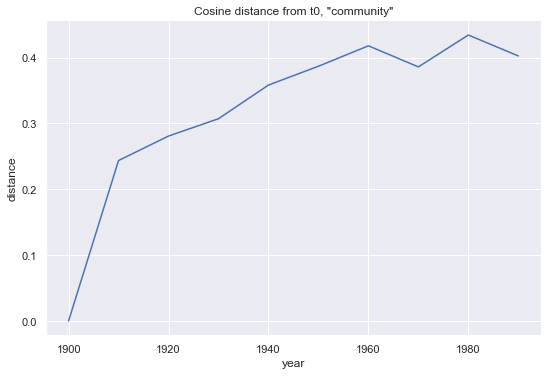

In [25]:
df_com0 = pd.DataFrame(emb_hist.keys(), columns = ["year"])
cos_dist = []
for year in emb_hist:
    # unitvec is in gensim.matutils
    cos_sim = np.dot(unitvec(emb_hist[1900]["community"]), 
                     unitvec(emb_hist[year]["community"]))
    cos_dist.append(1 - cos_sim)
df_com0["distance"] = cos_dist

g = sns.relplot(data=df_com0, x='year', y='distance', 
                kind="line")
g.ax.set_title('Cosine distance from t0, "community"')
g.fig.set_figwidth(8)
plt.show()

In [26]:
df_gay0 = pd.DataFrame(emb_hist.keys(), columns = ["year"])
cos_dist = []
for year in emb_hist:
    # unitvec is in gensim.matutils
    cos_sim = np.dot(unitvec(emb_hist[1900]["gay"]), 
                     unitvec(emb_hist[year]["gay"]))
    cos_dist.append(1 - cos_sim)
df_gay0["distance"] = cos_dist
df_gay0

,year,distance
0,1900,0.000000
1,1910,0.303669
2,1920,0.398048
3,1930,0.462475
4,1940,0.462247
5,1950,0.435994
6,1960,0.463119
7,1970,0.579974
8,1980,0.734762
9,1990,0.822387


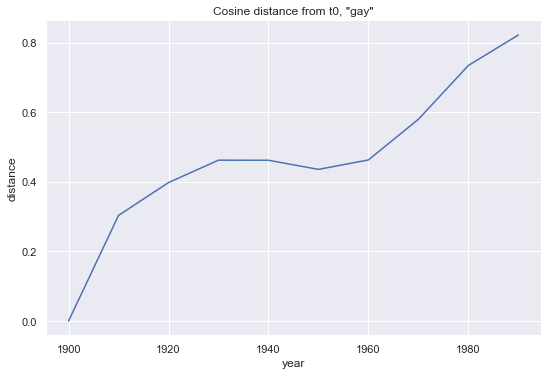

In [27]:
g = sns.relplot(data=df_gay0, x='year', y='distance', 
                kind="line")
g.ax.set_title('Cosine distance from t0, "gay"')
g.fig.set_figwidth(8)
plt.show()

In [28]:
df_tape0 = pd.DataFrame(emb_hist.keys(), columns = ["year"])
cos_dist = []
for year in emb_hist:
    # unitvec is in gensim.matutils
    cos_sim = np.dot(unitvec(emb_hist[1900]["tape"]), 
                     unitvec(emb_hist[year]["tape"]))
    cos_dist.append(1 - cos_sim)
df_tape0["distance"] = cos_dist

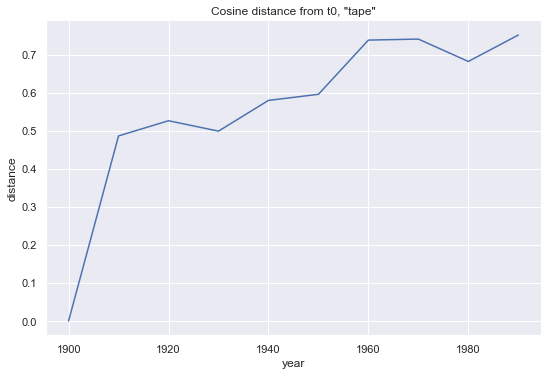

In [29]:
g = sns.relplot(data=df_tape0, x='year', y='distance', 
                kind="line")
g.ax.set_title('Cosine distance from t0, "tape"')
g.fig.set_figwidth(8)
plt.show()

In their Figure 5, Kulkarni et al use "tape" as another example of semantic change. They don't include t0, and they use 5-year increments instead of 10-year. Still, this doesn't seem to resemble their figure very closely, especially in terms of the large initial gap between the 1900s and 1910s.

## Word migration with t-SNE

As outlined above, I ran the histwords viz code in a separate environment and produced two-dimensional figures illustrating the movement of focal words over time. In addition to showing the magnitude of change, but conveys some information about what that change means in terms of a word's nearest neighbors.

The word "community" changes relatively little:  

![](img/community_annotated.png)

By comparison, the word "gay" migrates dramatically:

![](img/gay_annotated.png)

TODO: Finish writing a simple approximation of those visualizations, using either gensim or whatlies. The beginning of this code, for the 1990s only, is below.

In [30]:
def fit_tsne(values):
    # from histwords/viz/common.py
    mat = np.array(values)
    model = TSNE(n_components=2, random_state=0, learning_rate=150, init='pca')
    fitted = model.fit_transform(mat)
    return fitted

In [31]:
word_list = ["community"]
w, _ = zip(*emb_hist[1990].most_similar("community", topn=99))
word_list += list(w)

In [32]:
tsne_1990 = fit_tsne(emb_hist[1990][word_list])

In [33]:
df_1990 = pd.DataFrame({'word': word_list, 
                        'x': tsne_1990[:, 0], 
                        'y': tsne_1990[:, 1]
                       })

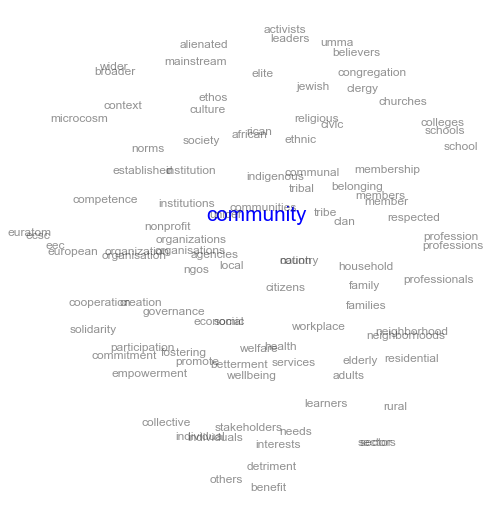

In [34]:
sns.set_style("white")
g = sns.relplot(x='x', y='y', data=df_1990, alpha=0)
g.set_axis_labels('', '')
g.despine(left=True, bottom=True)
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
for _, row in df_1990.iterrows():
    if row.word != 'community':
        g.ax.text(x=row.x, y=row.y, s=row.word, 
                  horizontalalignment='center',
                  verticalalignment='center',
                  alpha=.5)
    else:
        g.ax.text(x=row.x, y=row.y, s=row.word, 
                  c='blue',
                  horizontalalignment='center',
                  verticalalignment='center',
                  alpha=1, 
                  size="xx-large"
                 )
plt.show(g)

## Methods notes

### Matrix alignment

To orient multiple embedding models in the same directions in multidimensional vector space, the matrices of word vectors need to be aligned with each other. This is important when calculating or plotting distance metrics showing how a single word has moved or changed between the time periods represented by different models. As I understand it, matrix alignment *isn't* necessary for calculating and then comparing pairwise cosine similarities from each time period. 

Hamilton et al (2016) use [orthogonal procrustes matrix alignment](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem), which they argue is more robust than the alignment approach in Kulkarni et al (2015). 

[This gist](https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf) ports to gensim two functions from Hamilton, for intersecting the vocabularies of two models and then aligning those matrices using a combination of matrix multiplication and SVD. There's [another related gist](https://gist.github.com/tangert/106822a0f56f8308db3f1d77be2c7942) which intersects the vocabularies from any number of models, but it doesn't include the matrix algebra for actually aligning those models (despite comments to the contrary). 

I believe the HistWords matrices are released in their aligned versions, which means that matrix alignment is only necessary for **locally trained** historical embeddings models. It seems plausible to me that alignment could be used to compare distances across models differentiated by something other than time, for instance the GloVe models trained on wikipedia and twitter used in previous notebooks.

Stoltz and Taylor (2020) discuss the need for alignment; Kozlowski et al (2019) do not.
